# Exploring parallelism approaches

In this notebook, I will provide a quick overview of different parallelism approaches, and provide a functional example for each approach.

These methods are what makes it possible for labs like OpenAI to train models with hundreds of billions of parameters. By the end of this notebook, you should have a good understanding of the main parallelism methods and how to implement them at a high level.

Parallelism allows computation to be distributed accross different nodes, such as multiple GPUs on one machine or entirely separate machines. Although we'll run the code locally on one node for ease of reading, the options we'll explore are logically separated as they would be on different nodes.

We will explore three parallelism methods:
- Data parallelism: This involves storing the whole model on each node and processing data in parallel.
- Tensor parallelism: This involves storing part of the tensor on each node and joining them when needed.
- Pipeline parallelism: This involves storing stages of the model on each node and passing batches through.

We will use a 2-layer MLP as an example, but the methods can be extended naturally to more complex models and operations.

Most of the insights in this notebook are from a few select papers, mainly [PipeDream (PDF)](https://cs.stanford.edu/people/matei/papers/2019/sosp_pipedream.pdf), [Megatron-LM](https://arxiv.org/abs/1909.08053) and [Using DeepSpeed to train Megatron](https://arxiv.org/abs/2201.11990v1). Feel free to reach out to @mlpowered if you have any questions.

## Initial model

Here is our example model: a 2-layer MLP.

In [1]:
from torch import nn, Tensor, randint, rand
import torch


class MLP(nn.Module):

  def __init__(self, layer_1_in, layer_1_out, layer_2_out):
    super().__init__()
    self.w1 = nn.Linear(layer_1_in,layer_1_out)
    self.w2 = nn.Linear(layer_1_out,layer_2_out)

  def forward(self,x):
    x = self.w1(x)
    x = nn.ReLU()(x)
    x = self.w2(x)
    x = nn.Sigmoid()(x)
    return x

layer_1_in = 16
layer_1_out = 8
layer_2_in = layer_1_out
layer_2_out = 1
torch.manual_seed(40)
batch_size = 32
dataset_size = 320
lr = .5
x = rand([dataset_size, 16])
target = randint(0,2, [dataset_size,1], dtype=torch.float32)
model = MLP(layer_1_in, layer_1_out, layer_2_out)
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

And a simple training loop.

In [2]:
for i in range(10001):
  start = i*batch_size % dataset_size
  end = (i+1)*batch_size % dataset_size
  batch_x = x[start:end,:]
  batch_target = target[start:end,:]
  y = model(batch_x)
  loss = nn.BCELoss()
  output = loss(y, batch_target)
  model.zero_grad()
  output.backward()
  optimizer.step()
  if i%2000==0:
    print(f"loss at iteration {i}: {output.data:.3f}")

loss at iteration 0: 0.715
loss at iteration 2000: 0.415
loss at iteration 4000: 0.297
loss at iteration 6000: 0.238
loss at iteration 8000: 0.223
loss at iteration 10000: 0.199


Training works!

## Data parallelism

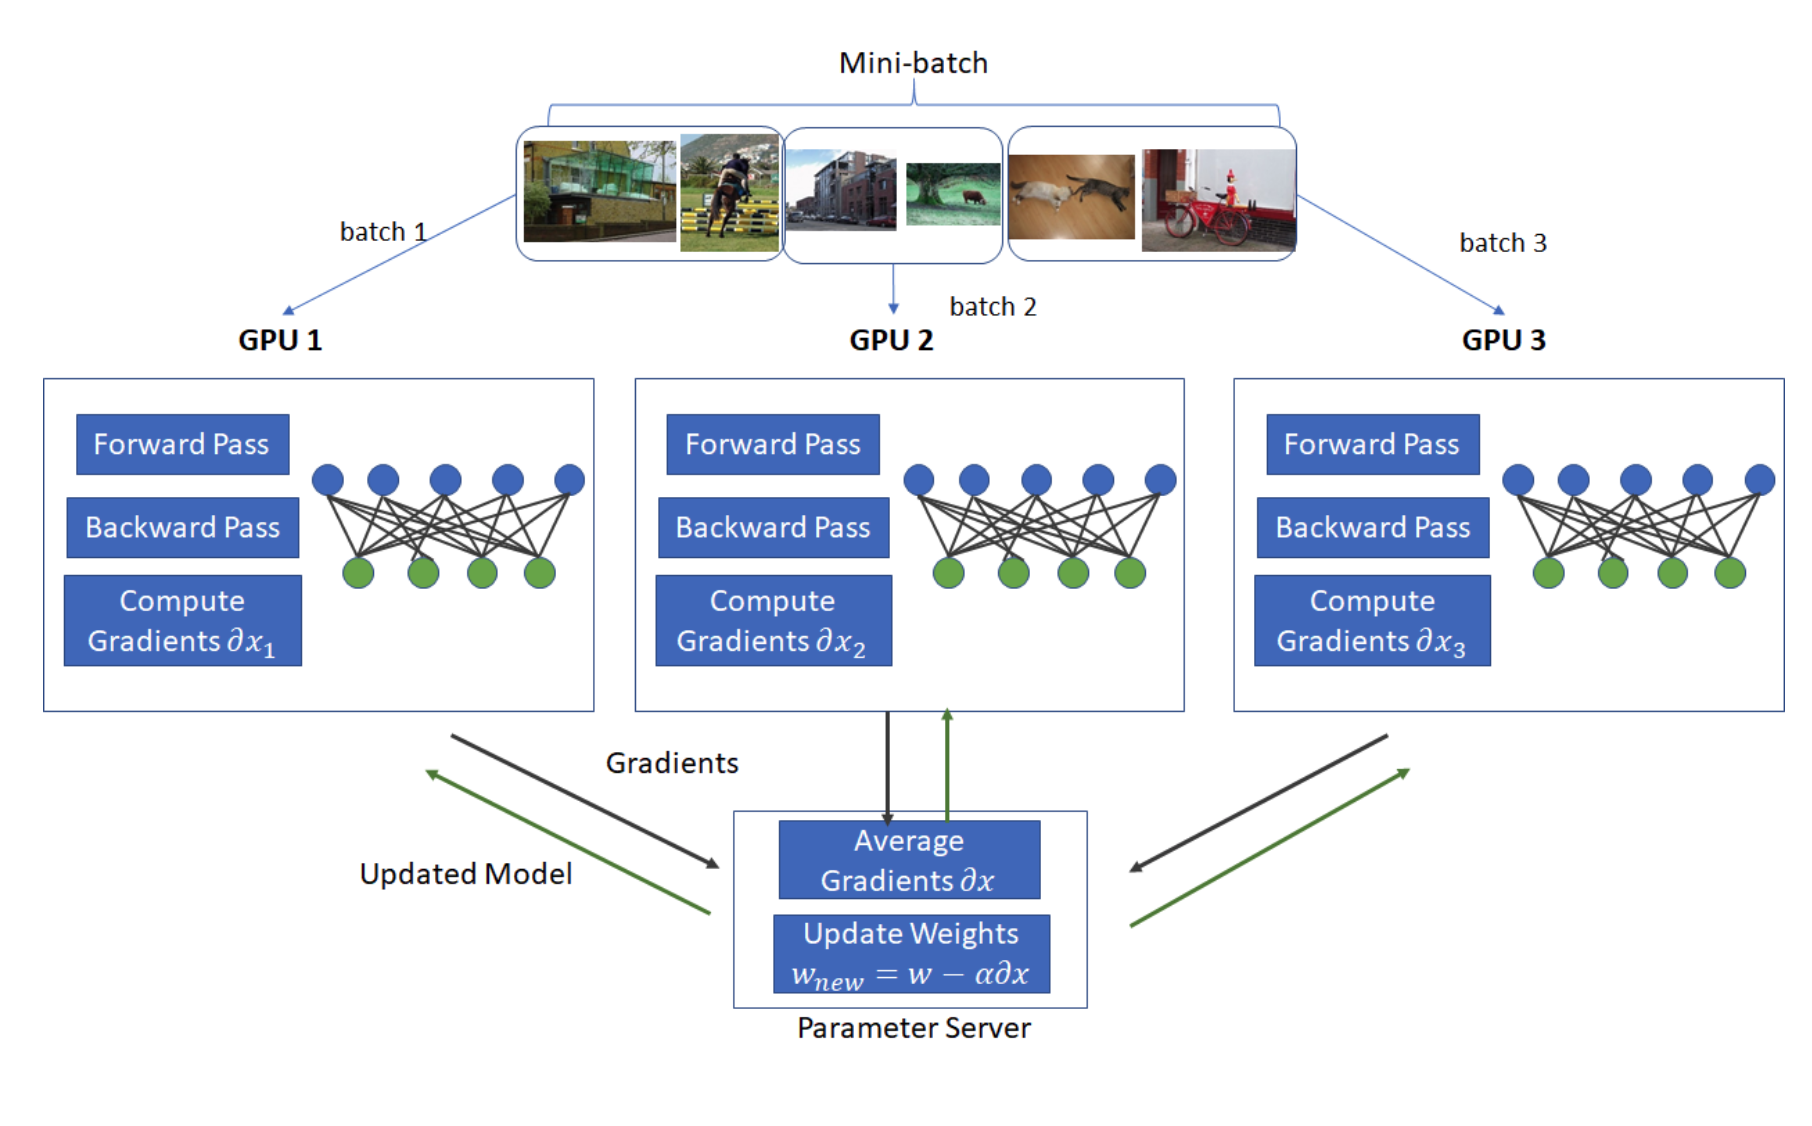

Illustration from [telesens](https://www.telesens.co/2017/12/25/understanding-data-parallelism-in-machine-learning/)

In data parallelism, we replicate the model on each node and send different data to each node. We then aggregate the gradients, update the weights, and dispatch the new weight values back to the nodes. 

This is by far the simplest approach for parallelism, but it isn't memory efficient as it requires replicating the full model on each node. It also encounters scaling limits once we reach very large batch sizes.

In [3]:
import copy
from collections import defaultdict

# redefine model copies for each node
model = MLP(layer_1_in, layer_1_out, layer_2_out)
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

loss = nn.BCELoss()
for i in range(5001):
  # copy model state to each node
  model_0 = copy.deepcopy(model)
  model_1 = copy.deepcopy(model)
  
  # Prepare a batch for each node
  start_0 = i*batch_size % dataset_size
  end_0 = (i+1)*batch_size % dataset_size
  start_1 = (i+1)*batch_size % dataset_size
  end_1 = (i+2)*batch_size % dataset_size
  batch_x_0 = x[start_0:end_0,:]
  batch_target_0 = target[start_0:end_0,:]
  batch_x_1 = x[start_1:end_1,:]
  batch_target_1 = target[start_1:end_1,:]

  # reset grads
  grads = defaultdict(list)

  # compute grads on node 0
  y_0 = model_0(batch_x_0)
  output_0 = loss(y_0, batch_target_0)
  model_0.zero_grad()
  output_0.backward()
  grads['w1_w'].append(model_0.w1.weight.grad)
  grads['w1_b'].append(model_0.w1.bias.grad)
  grads['w2_w'].append(model_0.w2.weight.grad)
  grads['w2_b'].append(model_0.w2.bias.grad)

  # compute grads on node 1
  y_1 = model_1(batch_x_1)
  output_1 = loss(y_1, batch_target_1)
  model_1.zero_grad()
  output_1.backward()
  grads['w1_w'].append(model_1.w1.weight.grad)
  grads['w1_b'].append(model_1.w1.bias.grad)
  grads['w2_w'].append(model_1.w2.weight.grad)
  grads['w2_b'].append(model_1.w2.bias.grad)

  # accumulate the gradients from the nodes and update the main model
  model.zero_grad()
  model.w1.weight.grad = sum(grads['w1_w'])
  model.w1.bias.grad = sum(grads['w1_b'])
  model.w2.weight.grad = sum(grads['w2_w'])
  model.w2.bias.grad = sum(grads['w2_b'])
  optimizer.step() 
  
  if i%1000==0:
    # print the average loss since batch sizes vary
    print(f"loss at iteration {i}: {(output_0.data + output_1.data) / 2:.3f}")

loss at iteration 0: 0.706
loss at iteration 1000: 0.467
loss at iteration 2000: 0.361
loss at iteration 3000: 0.347
loss at iteration 4000: 0.320
loss at iteration 5000: 0.293


Great! Training still works, and it only takes half the amount of iterations!

## Tensor parallelism

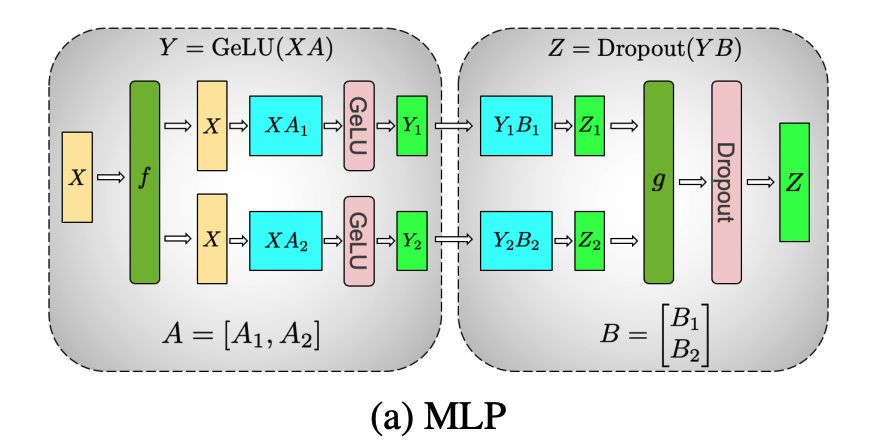

Illustration from [Megatron-LM](https://arxiv.org/abs/1909.08053)

### Idea
In tensor parallelism, we distribute the weights of each layer across different nodes.

For example, we can compute half of a dense layer on one node and the other half on another node. Both nodes then need to share results before the next layer.

### In practice
So, how do we implement this in our example?

If `x` has shape (batch, 16) and `W` has shape (16, 8), `y` has shape (batch, 8) calculated as shown below.

`y = X . W`

We define the left half of W `W_1=W[:,:4]` of shape (16,4) and W_2 the right half. 

We then have `y_1 = X . W_1` and `y_2 = X . W_2`, and we concatenate them to get `y = concat([y_1, y_2], axis=1)`

Once we've reconstructed `y`, we can pass it to each node for the next layer.

But how can we extend this to the second dense layer, which has shape (8,1)? We cannot split its second dimension, so we can choose to split the tensors down the input dimension. Check out the code to see it in practice.

### Takeaways
One takeaway about tensor parallelism is that it is architecture-specific and requires careful consideration of the compute graph.

Tensor parallelism is more memory efficient than data parallelism but still involves some duplication (such as activations). It requires more communication than data parallelism, so it is only appropriate if communication bandwidth is high.

In [4]:
model = MLP(layer_1_in, layer_1_out, layer_2_out)
loss = nn.BCELoss()

# distribute weights on nodes

# Layer 1
# we split the first layer along its output dimension
w1_node_0 = nn.Linear(layer_1_in, layer_1_out//2)
with torch.no_grad():
  w1_node_0.weight.copy_(model.w1.weight[:4,:])
  w1_node_0.bias.copy_(model.w1.bias[:4])

w1_node_1 = nn.Linear(layer_1_in, layer_1_out//2)
with torch.no_grad():
  w1_node_1.weight.copy_(model.w1.weight[4:,:])
  w1_node_1.bias.copy_(model.w1.bias[4:])

# Layer 2
# since the output of layer 2 is dimension 1, we split along the input dimension
w2_node_0 = nn.Linear(layer_2_in//2, layer_2_out)
with torch.no_grad():
  w2_node_0.weight.copy_(model.w2.weight[:,:4])
  w2_node_0.bias.copy_(model.w2.bias)

# since there is only one bias, we put it arbitrarily on node 0 so bias=False on node 1
# w2_node_1 = nn.Linear(*reversed(model.w2.weight[:,4:].shape), bias=False)
w2_node_1 = nn.Linear(layer_2_in//2, layer_2_out, bias=False)
with torch.no_grad():
  w2_node_1.weight.copy_(model.w2.weight[:,4:])

weights = [w1_node_0, w1_node_1, w2_node_0, w2_node_1]
# we'll have twice the effective batch size, so we double the lr
optimizers = [torch.optim.SGD(w.parameters(), lr=2*lr) for w in weights]

# since we split the model in half, we can double the batch size (ignoring activations for simplicity)
split_model_batch_size = 2 * batch_size
for i in range(5001):
  start = i*split_model_batch_size % dataset_size
  end = (i+1)*split_model_batch_size % dataset_size
  
  batch_x = x[start:end,:]
  batch_target = target[start:end,:]

  # layer 1 forward pass
  # node 0
  h1_node_0 = nn.ReLU()(w1_node_0(batch_x))
  # node 1
  h1_node_1 = nn.ReLU()(w1_node_1(batch_x))
  # gather activations to dispatch to both nodes
  h1 = torch.cat([h1_node_0,h1_node_1], axis=1)

  # layer 2 forward pass
  # node 0
  partial_sum_node_0 = w2_node_0(h1[:,:4])
  # node 1
  partial_sum_node_1 = w2_node_1(h1[:,4:])
  # gather output
  y = nn.Sigmoid()(partial_sum_node_0+partial_sum_node_1)
  output = loss(y, batch_target)

  # compute grads
  # we simplify here, in reality the backward pass would be distributed similarly to the forward pass
  # the logic is similar so we'll skip for readability. For example for layer 1:
  # if h = x . W^T and we have dh, dW^T = x^T . dh, so dW = dh^T . x
  # so we can get dW_1 by computing dh^T . x[:,:4] on node 1.
  for w in weights:
    w.zero_grad()
  output.backward()
  for o in optimizers:
    o.step()
    
  if i%1000==0:
    print(f"loss at iteration {i}: {output.data:.3f}")

loss at iteration 0: 0.693
loss at iteration 1000: 0.510
loss at iteration 2000: 0.367
loss at iteration 3000: 0.315
loss at iteration 4000: 0.298
loss at iteration 5000: 0.285


Once again, the loss is decreasing, and we are only going through half the iterations!

# Pipeline parallelism

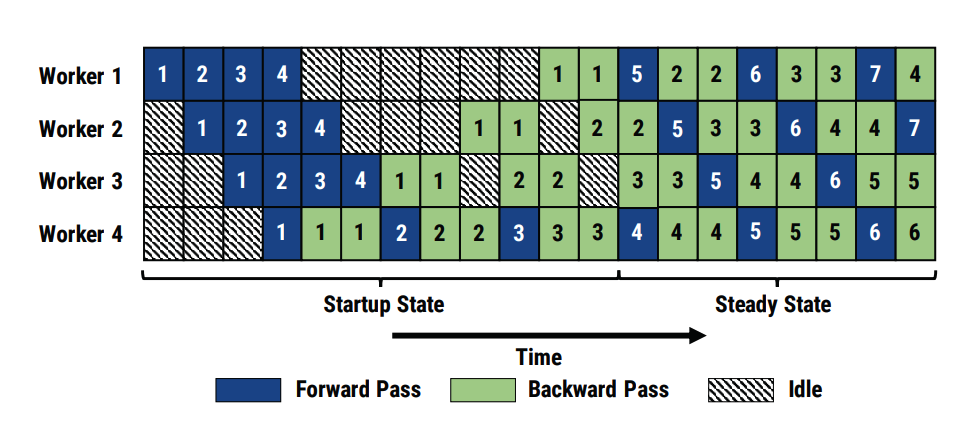

Figure from [PipeDream](https://www.microsoft.com/en-us/research/blog/pipedream-a-more-effective-way-to-train-deep-neural-networks-using-pipeline-parallelism/)

The concept behind pipeline parallelism is to distribute consecutive stages to different nodes. 

Each node computes continuously, but with different nodes working on different batches. We also need to allocate time for the backward pass computation for each batch.

We will use the f1b1 implementation, where each stage alternates between computing a forward and a backward pass. However, we need to make a few forward passes first before we can begin the backpropagation process.

Here's an example timing for dividing our 2-layer MLP into two stages in a pipeline.

When we start the pipeline, some nodes are idle waiting for input from upstream or downstream nodes:

| time         | node 0 / stage 0     | node 1 / stage 1 |
|--------------|-----------|------------|
| t(0) | forward(batch[0])      | idle        |
| t(1)      | forward(batch[1])  | forward(batch[0])       |
| t(2)      | idle  | backward(batch[0])       |



After the pipeline has started, all nodes are utilized continuously in the following regime:


| time         | node 0 / stage 0     | node 1 / stage 1 |
|--------------|-----------|------------|
| t(3)      | backward(batch[0])  | forward(batch[1])       |
| t(4)    | forward(batch[2])  | backward(batch[1])       |
| t(5)      | backward(batch[1])  | forward(batch[2])       |
| t(6)      | forward(batch[3])  | backward(batch[2])       |
...
| t(n)      | backward(batch[k])  | forward(batch[k+1])       |
| t(n+1)      | forward(batch[k+2])  | backward(batch[k+1])       |
| t(n+2)      | backward(batch[k+1])  | forward(batch[k+2])       |
| t(n+2)    | forward(batch[k+3])  | backward(batch[k+2])       |


There are many details to consider when implementing pipeline parallelism, as outlined in resources such as [Megatron](https://arxiv.org/abs/2201.11990v1) and [PipeDream](https://www.microsoft.com/en-us/research/blog/pipedream-a-more-effective-way-to-train-deep-neural-networks-using-pipeline-parallelism/).

In the following code, there is a significant omission that simplifies the implementation. Specifically, the same model is used for every forward and backward pass. However, when a forward pass is completed for a given batch on a specific node, the original model was used. Meanwhile, by the time the backward gradients are computed, the weights have already been updated using a previous batch, causing the gradients to reflect an outdated version of the weights. 

As models get larger, the problem mentioned earlier becomes more severe. This is because the weights are used to propagate gradients to the upstream layers, and using an outdated version of the weights will lead to incorrect gradient propagation. To overcome this, it is recommended to maintain multiple copies of the weights, one for each in-flight minibatch.

In this particular example, multiple weight copies are not used for the sake of readability, as the network is shallow enough to still train properly.

While pipeline parallelism is more memory-efficient than data parallelism, overhead costs are incurred for storing in-flight batch activations (and potentially weight copies). Nonetheless, it has the lowest communication overhead of the parallelism approaches discussed here.

In [5]:
# distribute weights on nodes

# node 0 is the first stage
class Stage0(nn.Module):

  def __init__(self):
    super().__init__()
    self.w1 = nn.Linear(16,8)

  def forward(self,x):
    x = self.w1(x)
    x = nn.ReLU()(x)
    return x

# node 1 is the second stage
class Stage1(nn.Module):

  def __init__(self):
    super().__init__()
    self.w2 = nn.Linear(8,1)

  def forward(self,x):
    x = self.w2(x)
    x = nn.Sigmoid()(x)
    return x

stages = [Stage0(), Stage1()]
optimizers = [torch.optim.SGD(s.parameters(), lr=lr) for s in stages]

stage_0_backward_queue = []
stage_1_forward_queue = []
stage_1_backward_queue = []

# keep track of whether the next step should be forward
forward_stage = [True, False]

# each nodes alternates between forwards and backwards pass
batch_idx = 0
while batch_idx < (10000):
  # node 0
  if forward_stage[0]:
    # add new batch to batch list
    start = batch_idx*batch_size % dataset_size
    end = (batch_idx+1)*batch_size % dataset_size
    if end==0:
      end = -1
    batch_x = x[start:end,:]
    batch_target = target[start:end,:]

    # forward pass and add to stage 1 queue, along with targets for loss computation
    stage_1_forward_queue.append((stages[0](batch_x),batch_target))
    
    if batch_idx%1000==3:
      print(f"loss at iteration {batch_idx}: {batch_loss.data:.3f}")
    batch_idx += 1

  else:
    # we skip this block if stage 1 hasn't sent gradients back yet
    if len(stage_0_backward_queue)>0:
      # grab the gradients from stage 1, and propagate them and update parameters
      output_with_grads = stage_0_backward_queue.pop(0)
      stages[0].zero_grad()
      output_with_grads.backward(gradient=output_with_grads.grad)
      optimizers[0].step()
  
  # node 1
  if forward_stage[1]:
    # grab output from stage 0 along with target, pass forward and store in queue for next backwards pass
    # we also store stage 0's output so we can pass it back along with its gradients after we backprop
    stage_0_output, batch_target = stage_1_forward_queue.pop(0)
    stage_1_backward_queue.append((stages[1](stage_0_output), stage_0_output, batch_target))
  else:
    # we check that we started the process and received gradients    
    if len(stage_1_backward_queue)>0:
      
      stages[1].zero_grad()
      stage_1_output, stage_0_output, batch_target = stage_1_backward_queue.pop(0)
      batch_loss = loss(stage_1_output, batch_target)

      # only backprop in the top stage variables since that is all we have on this node
      # we also want the grad for output so we can pass it to stage 0
      batch_loss.backward(inputs=[stages[1].w2.weight, stages[1].w2.bias, stage_0_output], retain_graph=True)
      stage_0_backward_queue.append(stage_0_output)
      optimizers[1].step()
  
  
  # at first, we have nothing to backprop, so we keep passing examples forward in stage 0
  if batch_idx>2:
    forward_stage[0] = not forward_stage[0]
  else:
    print(f"Filling pipeline to start, batch {batch_idx-1}")
  forward_stage[1] = not forward_stage[1]

Filling pipeline to start, batch 0
Filling pipeline to start, batch 1
loss at iteration 3: 0.691
loss at iteration 1003: 0.599
loss at iteration 2003: 0.423
loss at iteration 3003: 0.367
loss at iteration 4003: 0.348
loss at iteration 5003: 0.330
loss at iteration 6003: 0.426
loss at iteration 7003: 0.334
loss at iteration 8003: 0.276
loss at iteration 9003: 0.280


Voila! Training still works. While we continue to use the same number of iterations as before, each iteration now takes half the time since we have two nodes working in parallel (assuming we actually distributed the code).

While there are other parallelism methods, they are outside the scope of this post. For those interested, I recommend exploring [ZeRO](https://arxiv.org/abs/1910.02054), which elegantly combines all these methods together.